In [ ]:
import numpy as np 
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
import os
#import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import Sequential
from tensorflow.keras.applications import InceptionResNetV2, DenseNet169, ResNet152V2, ResNet50
from tensorflow.keras.layers import Dense

# Time everything in IPython
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.9 MB/s eta 0:00:00
time: 658 µs (started: 2023-04-25 15:06:40 +00:00)


In [ ]:
# Mount Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 18.3 s (started: 2023-04-25 15:06:40 +00:00)


In [ ]:
train_image_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/train_images'
test_image_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/test_images' 
train_df_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/train.csv'
test_df_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/sample_submission.csv'

time: 556 µs (started: 2023-04-25 15:06:58 +00:00)


In [ ]:
df_train = pd.read_csv(train_df_path)
df_test=pd.read_csv(test_df_path)

time: 1.22 s (started: 2023-04-25 15:06:58 +00:00)


In [ ]:
print(df_test)

                  image   labels
0  85f8cb619c66b863.jpg  healthy
1  ad8770db05586b59.jpg  healthy
2  c7b03e718489f3ca.jpg  healthy
time: 10.8 ms (started: 2023-04-25 15:06:59 +00:00)


In [ ]:
df_train = df_train[(df_train['labels'] == 'healthy') | (df_train['labels'] == 'scab')]

time: 8.62 ms (started: 2023-04-25 15:06:59 +00:00)


In [ ]:
print(df_train)

                      image   labels
0      800113bb65efe69e.jpg  healthy
2      80070f7fb5e2ccaa.jpg     scab
3      80077517781fb94f.jpg     scab
5      800edef467d27c15.jpg  healthy
7      801d6dcd96e48ebc.jpg  healthy
...                     ...      ...
18625  fffaa4a0fe416808.jpg     scab
18626  fffb65761200b054.jpg  healthy
18627  fffb900a92289a33.jpg  healthy
18628  fffc488fa4c0e80c.jpg     scab
18631  fffe472a0001bd25.jpg  healthy

[9450 rows x 2 columns]
time: 2.93 ms (started: 2023-04-25 15:06:59 +00:00)


In [ ]:
train_df, dummy_df = train_test_split(df_train,  train_size= 0.70, shuffle= True,random_state=123)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.30, shuffle= True,random_state=123)

time: 3.9 ms (started: 2023-04-25 15:06:59 +00:00)


In [ ]:
CLASSES = df_train['labels'].unique().tolist()
print(CLASSES)

['healthy', 'scab']
time: 2.92 ms (started: 2023-04-25 15:06:59 +00:00)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_dataframe(
   train_df, directory= train_image_path, x_col= 'image', y_col= 'labels', target_size= (224,224),
                                            class_mode= 'categorical',shuffle= True, batch_size= 64)
val_generator = train_datagen.flow_from_dataframe(
   valid_df, directory= train_image_path, x_col= 'image', y_col= 'labels', target_size= (224,224),
                                            class_mode= 'categorical', shuffle= True, batch_size= 64)
test_generator = train_datagen.flow_from_dataframe(
   test_df, directory= train_image_path, x_col= 'image', y_col= 'labels', target_size= (224,224),
                                            class_mode= 'categorical',shuffle= False, batch_size= 64)

Found 6615 validated image filenames belonging to 2 classes.
Found 850 validated image filenames belonging to 2 classes.
Found 1985 validated image filenames belonging to 2 classes.
time: 1min 51s (started: 2023-04-25 15:06:59 +00:00)


In [ ]:
#load the ResNet50 model
res50 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
ResNet50.trainable = False # https://stackoverflow.com/questions/58224816/what-does-model-trainable-false-mean-in-keras
print(res50.summary())


94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
model = tf.keras.models.Sequential([
    res50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

time: 470 ms (started: 2023-04-25 15:09:00 +00:00)


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 23,735,298
Non-trainable params: 53,120
_________________________________________________________________
None
time: 50.7 ms (started: 2023-04-25 15:09:00 +00:00)


In [ ]:
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=8,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[earlystop]

time: 408 µs (started: 2023-04-25 15:09:00 +00:00)


In [ ]:
c = model.fit(
    train_generator,
    steps_per_epoch = 6611//64,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = (935//64),
    max_queue_size=100,
    workers = 4 ,
    verbose = 1,
callbacks=callbacks)

Epoch 1/10
103/103 [==============================] - 1373s 13s/step - loss: 2.5244 - accuracy: 0.7004 - val_loss: 28.9930 - val_accuracy: 0.5235
Epoch 2/10
103/103 [==============================] - 553s 5s/step - loss: 1.1064 - accuracy: 0.7880 - val_loss: 1.5721 - val_accuracy: 0.5271
Epoch 3/10
103/103 [==============================] - 522s 5s/step - loss: 1.0876 - accuracy: 0.8519 - val_loss: 0.6928 - val_accuracy: 0.5271
Epoch 4/10
103/103 [==============================] - 545s 5s/step - loss: 0.6958 - accuracy: 0.8828 - val_loss: 2.0381 - val_accuracy: 0.5271
Epoch 5/10
103/103 [==============================] - 526s 5s/step - loss: 0.8234 - accuracy: 0.9005 - val_loss: 0.6711 - val_accuracy: 0.5271
Epoch 6/10
103/103 [==============================] - 496s 5s/step - loss: 0.1535 - accuracy: 0.9432 - val_loss: 0.6924 - val_accuracy: 0.5271
Epoch 7/10
103/103 [==============================] - 554s 5s/step - loss: 0.0970 - accuracy: 0.9647 - val_loss: 0.8615 - val_accuracy: 0.5

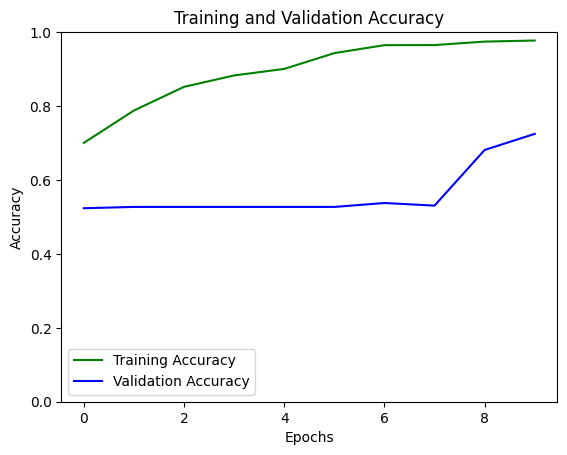

time: 793 ms (started: 2023-04-25 16:54:12 +00:00)


In [ ]:
acc_train=c.history['accuracy']
acc_val=c.history['val_accuracy']
epochs=range(len(acc_train))
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

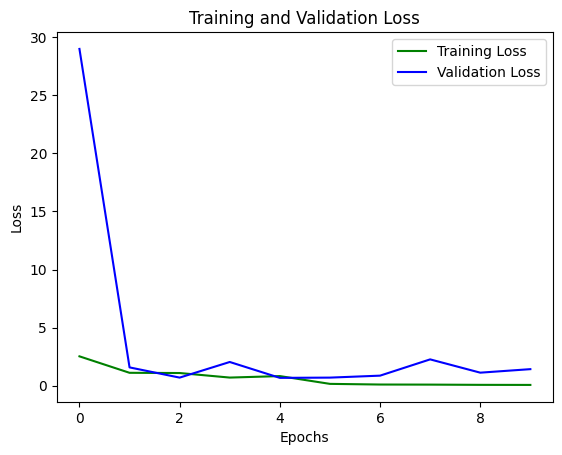

time: 313 ms (started: 2023-04-25 16:59:22 +00:00)


In [ ]:
loss_train=c.history['loss']
loss_val=c.history['val_loss']
epochs=range(len(loss_train))
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
train_accuracy = model.evaluate(train_generator,batch_size=128)[1] * 100
print('Train accuracy is : ',train_accuracy, '%' )

104/104 [==============================] - 917s 9s/step - loss: 1.2956 - accuracy: 0.7231
Train accuracy is :  72.30536937713623 %
time: 15min 30s (started: 2023-04-25 16:59:37 +00:00)


In [ ]:
val_accuracy = model.evaluate(val_generator,batch_size=64)[1] * 100
print('val accuracy is : ',val_accuracy, '%' )

14/14 [==============================] - 114s 8s/step - loss: 1.4208 - accuracy: 0.7247
val accuracy is :  72.47058749198914 %
time: 2min 2s (started: 2023-04-25 17:17:54 +00:00)


In [ ]:
test_accuracy = model.evaluate(test_generator,batch_size=64)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

32/32 [==============================] - 1223s 39s/step - loss: 1.3445 - accuracy: 0.7214
Test accuracy is :  72.14105725288391 %
time: 21min 5s (started: 2023-04-25 17:21:22 +00:00)


In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

time: 657 µs (started: 2023-04-25 17:43:39 +00:00)


In [ ]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict(test_generator, steps = test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)

32/32 [==============================] - 259s 8s/step
time: 4min 27s (started: 2023-04-25 17:43:41 +00:00)


In [ ]:
import sklearn
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report) 

              precision    recall  f1-score   support

     healthy       0.64      1.00      0.78       967
        scab       0.99      0.46      0.63      1018

    accuracy                           0.72      1985
   macro avg       0.82      0.73      0.70      1985
weighted avg       0.82      0.72      0.70      1985

time: 13.5 ms (started: 2023-04-25 17:51:02 +00:00)


<Figure size 200x200 with 0 Axes>

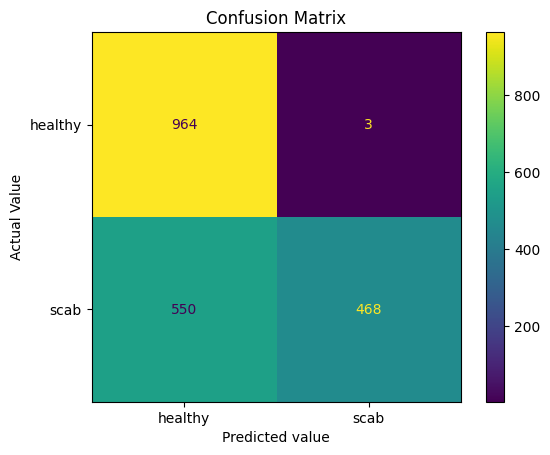

time: 256 ms (started: 2023-04-25 17:51:04 +00:00)


In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
x=confusion_matrix(true_classes, predicted_classes)

x_display=metrics.ConfusionMatrixDisplay(confusion_matrix=x,display_labels=class_labels)
plt.figure(figsize=(2,2))
x_display.plot()

plt.title("Confusion Matrix")
plt.xlabel("Predicted value")
plt.ylabel("Actual Value")
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


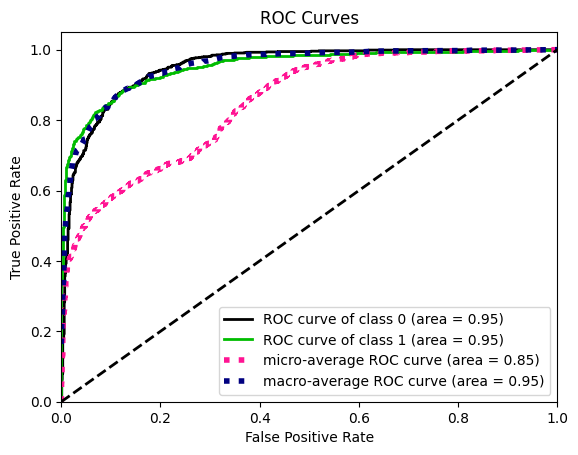

<Figure size 200x200 with 0 Axes>

time: 6.22 s (started: 2023-04-25 17:51:06 +00:00)


In [ ]:
! pip install scikit-plot

import scikitplot as skplt

y_true = true_classes
y_probas = predictions
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.figure(figsize=(2,2))
plt.show()